## Детекция дефектов металлических пластин
Данный notebook является примером решения задачи [Severstal: Steel Defect Detection](https://www.kaggle.com/competitions/severstal-steel-defect-detection/data). Для решения была использована модель YOLOv8, как одна из самых быстро обучаемых моделей для семантической сегментации. Кроме того, данная модель позволяет проводить комфортное использование для потокового видео 

In [8]:
import pandas as pd
import numpy as np
import random
import os

import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import shutil
from sklearn.model_selection import train_test_split

from ultralytics import YOLO

## Загрузка данных и первичный анализ

In [2]:
# чтение файла данных
df = pd.read_csv(r'data\train.csv')
df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [43]:
# проверяем на пустые значения
df.isna().sum()

ImageId          0
ClassId          0
EncodedPixels    0
dtype: int64

<Axes: xlabel='ClassId'>

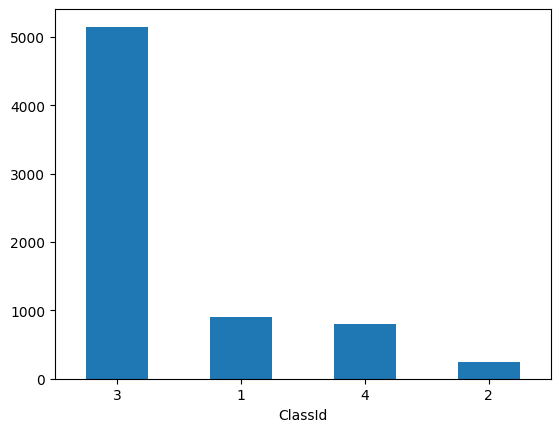

In [44]:
# соотношение классов
df['ClassId'].value_counts().plot(kind='bar', rot=0)

In [45]:
# посмотрим, есть ли у на одном фото разные дефекты
df_sort = df.groupby('ImageId').nunique().sort_values(by = 'ClassId', ascending = False)
df_sort[df_sort['ClassId'] != 1]

,ClassId,EncodedPixels
ImageId,,
ef24da2ba.jpg,3,3
db4867ee8.jpg,3,3
84865746c.jpg,2,2
5665ada1b.jpg,2,2
eb44ad79d.jpg,2,2
...,...,...
c389100a5.jpg,2,2
ff6bfada2.jpg,2,2
00c88fed0.jpg,2,2


In [46]:
# доля фотографий с дефектами разных классов
len(df_sort[df_sort['ClassId'] != 1]) / len(df)

0.06018322762508809

Итого, у нас дисбаланс классов, и у 6% пластин есть дефекты разного типа 

## Готовим аннотации для YOLO

In [47]:
TRAIN_IMAGE_DATASET_PATH = r'data\train_images'

def read_image_with_masks(row, df):
    """
    Считывает изображение с масками для объектов, соответствующих указанной строке row в датафрейме df.

    Параметры:
    - row: Строка датафрейма, содержащая информацию о конкретном изображении и его масках.
    - df: Датафрейм с информацией о масках объектов на изображениях.

    Возвращаемое значение:
    Кортеж, содержащий список масок, список соответствующих классов объектов и имя файла изображения.
    """
    fname_o = row['ImageId']
    fname = TRAIN_IMAGE_DATASET_PATH + '/' + fname_o

    labels = row[['ClassId', 'EncodedPixels']]
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    shape = image.shape

    list_with_all_masks = []
    list_names = []

    if not pd.isnull(labels['EncodedPixels']):
        string_array = labels['EncodedPixels'].split()
        int_array = [int(string) for string in string_array]
        object_mask = create_mask(int_array, shape)

        list_with_all_masks.append(object_mask)
        list_names.append(int(labels['ClassId']))

    return list_with_all_masks, list_names, fname_o

def create_mask(int_array, shape):
    """
    Преобразование маски в двумерный массив бинарных значений.

    Параметры:
    - int_array: Список целых чисел, представляющих закодированную маску объекта.
    - shape: Размеры изображения.

    Возвращаемое значение:
    Двумерный массив бинарных значений, представляющий маску объекта.
    """
    result = np.zeros((shape[0], shape[1]), dtype=np.float32)
    positions = map(int, int_array[0::2])
    length = map(int, int_array[1::2])
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for pos, le in zip(positions, length):
        mask[pos:(pos + le)] = 1
    result[:, :] = mask.reshape(shape[0], shape[1], order='F')

    binary_mask = result.astype(np.uint8)
    return binary_mask

def convert_mask_to_polygons(binary_mask) -> list[list[int | float]]:
    """
    Преобразование бинарной маски объекта в список полигонов с использованием контуров.

    Параметры:
    - binary_mask: Двумерный массив бинарных значений, представляющий маску объекта.

    Возвращаемое значение:
    Список полигонов, представленных в виде списков координат.
    """
    annotations = []

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)

    wh = np.flip(np.array(binary_mask.shape))

    for contour in contours:
        epsilon = 0.001 * cv2.arcLength(contour, True)
        contour_approx = cv2.approxPolyDP(contour, epsilon, True)
        contour_approx = contour_approx / wh

        polygon = contour_approx.flatten().tolist()
        annotations.append(polygon)
    return annotations


def convert_masks_to_xy(masks, class_labels):
    """
    Преобразование массива масок объектов в список полигонов с соответствующими классами объектов.

    Параметры:
    - masks: Список масок объектов.
    - class_labels: Список классов соответствующих маскам объектов.

    Возвращаемое значение:
    Список полигонов и соответствующих классов объектов.
    """
    list_with_all_masks = []
    list_names = []

    for i, mask in enumerate(masks):
        xy_arr = convert_mask_to_polygons(mask)
        for xy_sequence in xy_arr:
            list_with_all_masks.append(xy_sequence)
            list_names.append(int(class_labels[i]))

    return list_with_all_masks, list_names

def process_dataset(df):
    """
    Обрабатывает весь датасет, извлекая информацию о масках, преобразуя их в формат полигонов и подготавливая данные для дальнейшей обработки.

    Параметры:
    - df: Датафрейм с информацией о масках объектов на изображениях.

    Возвращаемое значение:
    Список словарей, каждый из которых содержит информацию об изображении, его аннотациях и классах объектов.
    """

    all_data = []

    for _, row in df.iterrows():
        masks, class_labels, fname_o = read_image_with_masks(row, df)
        keypoints, class_labels = convert_masks_to_xy(masks, class_labels)
        all_data.append({'file_name': fname_o, 'annotations': keypoints, 'class_labels': class_labels})

    return all_data

In [49]:
# запуск функций для датафрейма
df_yolo = pd.DataFrame(process_dataset(df))
df_yolo.head()

,file_name,annotations,class_labels
0,0002cc93b.jpg,"[[0.221875, 0.75390625, 0.220625, 0.7578125, 0...","[1, 1, 1, 1, 1, 1]"
1,0007a71bf.jpg,"[[0.04625, 0.57421875, 0.04625, 0.6796875, 0.0...","[3, 3, 3]"
2,000a4bcdd.jpg,"[[0.274375, 0.91015625, 0.274375, 0.91796875, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
3,000f6bf48.jpg,"[[0.533125, 0.80078125, 0.561875, 0.88671875, ...","[4, 4, 4]"
4,0014fce06.jpg,"[[0.57375, 0.23828125, 0.568125, 0.25390625, 0...",[3]


In [50]:
# объединяем дефекты разного класса в общую аннотацию
df_yolo_2 = df_yolo.copy()

df_yolo_2['annotations'] = df_yolo_2.groupby('file_name')['annotations'].transform('sum')
df_yolo_2['class_labels'] = df_yolo_2.groupby('file_name')['class_labels'].transform('sum')
df_yolo_2 = df_yolo_2.drop_duplicates(subset=['file_name'])
df_yolo_2.head(10)

,file_name,annotations,class_labels
0,0002cc93b.jpg,"[[0.221875, 0.75390625, 0.220625, 0.7578125, 0...","[1, 1, 1, 1, 1, 1]"
1,0007a71bf.jpg,"[[0.04625, 0.57421875, 0.04625, 0.6796875, 0.0...","[3, 3, 3]"
2,000a4bcdd.jpg,"[[0.274375, 0.91015625, 0.274375, 0.91796875, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
3,000f6bf48.jpg,"[[0.533125, 0.80078125, 0.561875, 0.88671875, ...","[4, 4, 4]"
4,0014fce06.jpg,"[[0.57375, 0.23828125, 0.568125, 0.25390625, 0...",[3]
5,0025bde0c.jpg,"[[0.538125, 0.375, 0.53, 0.375, 0.52875, 0.378...","[3, 3, 3, 3, 3, 3, 4, 4]"
7,002af848d.jpg,"[[0.765, 0.96875, 0.764375, 0.96484375, 0.7637...","[4, 4]"
8,002fc4e19.jpg,"[[0.365, 0.328125, 0.36125, 0.33984375, 0.3606...","[1, 2, 2]"
10,0030401a5.jpg,"[[0.455625, 0.81640625, 0.456875, 0.83203125, ...","[4, 4, 4]"
11,0046839bd.jpg,"[[0.373125, 0.3671875, 0.375625, 0.37890625, 0...",[3]


In [51]:
# проверим, что у нас все вышло правильно
len(df_yolo_2['annotations'][5]) == len(df_yolo_2['class_labels'][5])

True

Создаем файлы-аннотации

In [54]:
output_folder = 'data/labels'

# проходим по каждой строке в датасете
for index, row in df_yolo_2.iterrows():
    file_name = row['file_name']
    annotations = row['annotations']
    class_labels = row['class_labels']

    # создаем путь для сохранения файла аннотации
    annotation_path = os.path.join(output_folder, os.path.splitext(file_name)[0] + '.txt')

    with open(annotation_path, 'w') as annotation_file:
        # проходим по каждой аннотации и классу в текущей строке
        for i in range(len(annotations)):
            annotation = annotations[i]
            class_label = class_labels[i]

            # записываем класс и координаты аннотации в файл
            annotation_line = f"{class_label} {' '.join(map(str, annotation))}\n"
            annotation_file.write(annotation_line)

## Убедимся, что мы все сделали правильно

In [55]:
# путь к папке с изображениями
images_folder = 'data/train_images'

# путь к папке с аннотациями
annotations_folder = 'data/labels'

# получаем список файлов в папке с изображениями
image_files = os.listdir(images_folder)[:10]  # Выбираем первые 10 изображений

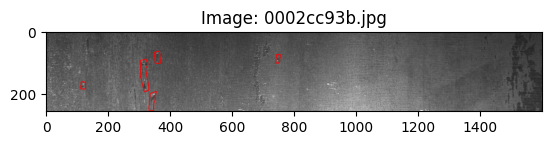

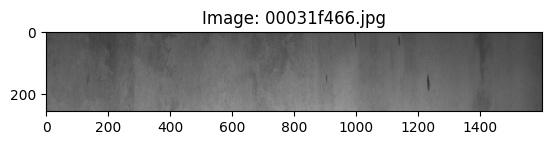

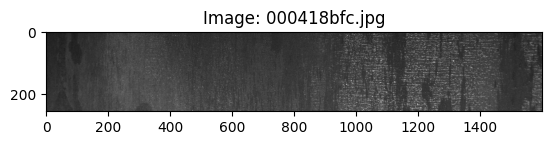

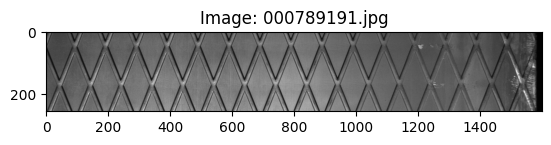

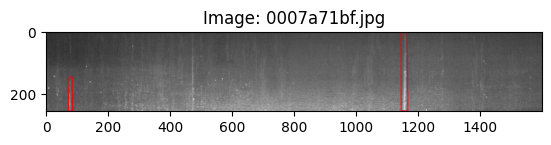

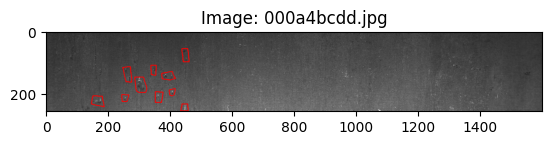

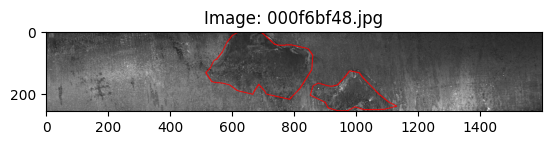

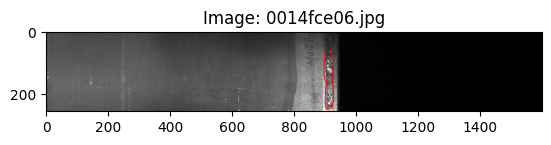

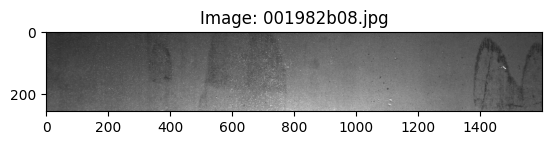

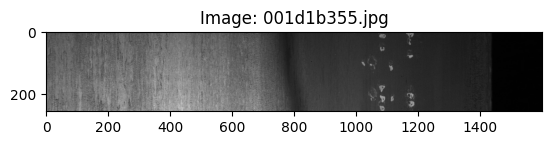

In [56]:
# проходим по каждому изображению
for image_file in image_files:
    # читаем изображение
    image_path = os.path.join(images_folder, image_file)
    image = cv2.imread(image_path)

    # получаем соответствующий файл аннотации
    annotation_file = os.path.join(annotations_folder, os.path.splitext(image_file)[0] + '.txt')

    # если файл аннотации существует, обрабатываем его
    if os.path.exists(annotation_file):
        with open(annotation_file, 'r') as annotation_file:
            # читаем аннотации из файла
            annotations = annotation_file.readlines()

            # проходим по каждой аннотации и рисуем её на изображении
            for annotation in annotations:
                parts = annotation.split()
                class_label = int(parts[0])
                points = list(map(float, parts[1:]))
                points = [(int(points[i] * image.shape[1]), int(points[i + 1] * image.shape[0])) for i in range(0, len(points), 2)]

                # рисуем маску на изображении с контуром нужного цвета
                cv2.polylines(image, [np.array(points)], isClosed=True, color=(0, 0, 255), thickness=2)

    # отображаем изображение с маской
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image: {image_file}")
    plt.show()

## Создание тренировочного и валидационного датасетов

In [59]:
# пути к папкам и файлам
train_images_folder = "data/train_images"
labels_folder = "data/labels"
train_images_output_folder = "data/train/images"
train_annotations_output_folder = "data/train/labels"
val_images_output_folder = "data/val/images"
val_annotations_output_folder = "data/val/labels"

# создаем папки для тренировочных и валидационных данных
os.makedirs(train_images_output_folder, exist_ok=True)
os.makedirs(train_annotations_output_folder, exist_ok=True)
os.makedirs(val_images_output_folder, exist_ok=True)
os.makedirs(val_annotations_output_folder, exist_ok=True)

# считываем аннотации и изображения
annotations_files = os.listdir(labels_folder)
annotations_files.sort()

# разделяем данные на тренировочные и валидационные с сохранением соотношения классов
annotations_train, annotations_val = train_test_split(annotations_files, test_size=0.2, random_state=42, stratify=[int(open(os.path.join(labels_folder, annotation_file)).readline().split()[0]) for annotation_file in annotations_files])

# копируем изображения и аннотации в соответствующие папки
def copy_data(annotations_list, input_folder, output_images_folder, output_annotations_folder):
    for annotation_file in annotations_list:
        image_file = os.path.splitext(annotation_file)[0] + ".jpg"
        
        # копируем изображение
        shutil.copy2(os.path.join(train_images_folder, image_file), os.path.join(output_images_folder, image_file))
        
        # копируем аннотацию
        shutil.copy2(os.path.join(labels_folder, annotation_file), os.path.join(output_annotations_folder, annotation_file))

# копируем тренировочные данные
copy_data(annotations_train, train_images_folder, train_images_output_folder, train_annotations_output_folder)

# копируем валидационные данные
copy_data(annotations_val, train_images_folder, val_images_output_folder, val_annotations_output_folder)

## Обучаем модель YOLOv8

In [4]:
# загружаем модель
model = YOLO('yolov8x-seg.pt')

100%|██████████| 137M/137M [00:13<00:00, 10.9MB/s] 


In [5]:
# запускаем обучение
model.train(data='data\data.yaml', epochs = 20)

Ultralytics YOLOv8.1.9 🚀 Python-3.11.7 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=data\data.yaml, epochs=20, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

100%|██████████| 6.23M/6.23M [00:02<00:00, 2.79MB/s]


AMP: checks passed ✅


train: Scanning C:\Users\SystemX\Desktop\ССССП\data\train\labels.cache... 5332 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5332/5332 [00:00<?, ?it/s]
val: Scanning C:\Users\SystemX\Desktop\ССССП\data\val\labels.cache... 6666 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6666/6666 [00:00<?, ?it/s]


Plotting labels to runs\segment\train4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\segment\train4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      14.7G      1.909      2.959      2.076      1.306         21        640: 100%|██████████| 334/334 [48:53<00:00,  8.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:56<00:00,  1.13s/it]


                   all       6666      23805      0.509      0.242      0.204     0.0893      0.466      0.194      0.157     0.0585

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      15.5G      1.905      2.833      1.794      1.317         17        640: 100%|██████████| 334/334 [1:14:51<00:00, 13.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [07:16<00:00,  2.09s/it]


                   all       6666      23805      0.701      0.164      0.152     0.0608      0.673      0.144      0.107     0.0371

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      15.4G      1.854      2.786      1.736      1.283         38        640: 100%|██████████| 334/334 [59:12<00:00, 10.64s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [05:05<00:00,  1.46s/it]


                   all       6666      23805      0.364      0.269      0.228     0.0984      0.294      0.211      0.163     0.0577

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      15.5G      1.797      2.697      1.668       1.26         19        640: 100%|██████████| 334/334 [1:14:10<00:00, 13.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [05:15<00:00,  1.51s/it]


                   all       6666      23805      0.387      0.269      0.241      0.108      0.364      0.229      0.192     0.0714

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      15.3G      1.764      2.662      1.615      1.229         26        640: 100%|██████████| 334/334 [54:55<00:00,  9.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [05:04<00:00,  1.46s/it]


                   all       6666      23805      0.404      0.339      0.293       0.13      0.343      0.293       0.23     0.0817

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      15.4G      1.706      2.582      1.551      1.203         38        640: 100%|██████████| 334/334 [1:18:24<00:00, 14.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [04:55<00:00,  1.41s/it]


                   all       6666      23805      0.469      0.336      0.313      0.144      0.417      0.298      0.267     0.0986

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      15.3G      1.696       2.56      1.518      1.193         23        640: 100%|██████████| 334/334 [1:05:17<00:00, 11.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [08:19<00:00,  2.39s/it]


                   all       6666      23805      0.476      0.316      0.304      0.137      0.388      0.284      0.237     0.0849

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      15.4G       1.66      2.517      1.468      1.179         20        640: 100%|██████████| 334/334 [1:17:57<00:00, 14.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [04:38<00:00,  1.33s/it]


                   all       6666      23805      0.456      0.377      0.343      0.159      0.389      0.322      0.272      0.103

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      15.5G      1.629      2.484      1.432      1.167         22        640: 100%|██████████| 334/334 [1:11:54<00:00, 12.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [09:18<00:00,  2.67s/it]


                   all       6666      23805      0.486      0.369      0.356      0.162      0.396      0.304      0.264     0.0945

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      15.3G      1.602       2.45      1.406      1.155         36        640: 100%|██████████| 334/334 [1:20:55<00:00, 14.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [06:47<00:00,  1.95s/it]


                   all       6666      23805      0.464      0.389      0.372      0.178      0.409      0.346      0.304      0.115
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      15.2G       1.65      2.512      1.476      1.186         14        640: 100%|██████████| 334/334 [1:14:22<00:00, 13.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


                   all       6666      23805       0.49       0.37      0.359      0.169      0.441      0.332      0.309      0.118

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      15.2G      1.625      2.457      1.438      1.183         13        640: 100%|██████████| 334/334 [1:11:24<00:00, 12.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [05:20<00:00,  1.53s/it]


                   all       6666      23805      0.535      0.392      0.396      0.183      0.443      0.333        0.3       0.11

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      15.3G      1.599      2.393        1.4      1.171          7        640: 100%|██████████| 334/334 [1:12:17<00:00, 12.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [06:40<00:00,  1.92s/it]


                   all       6666      23805      0.512      0.412      0.396      0.188      0.427      0.345      0.304      0.116

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      15.2G      1.582      2.421      1.368      1.159          7        640: 100%|██████████| 334/334 [1:09:46<00:00, 12.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [07:27<00:00,  2.14s/it]


                   all       6666      23805      0.505      0.372      0.374      0.178      0.391      0.309      0.269     0.0977

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      15.3G      1.562      2.386      1.333      1.152          9        640: 100%|██████████| 334/334 [1:04:05<00:00, 11.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:54<00:00,  1.12s/it]


                   all       6666      23805      0.527      0.419       0.42      0.204      0.433      0.367      0.319      0.123

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      15.3G       1.53      2.307      1.304      1.139         11        640: 100%|██████████| 334/334 [1:16:17<00:00, 13.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [04:58<00:00,  1.43s/it]


                   all       6666      23805      0.542      0.436      0.434      0.215       0.47      0.387      0.365       0.14

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      15.2G      1.512      2.334       1.28      1.127          6        640: 100%|██████████| 334/334 [55:35<00:00,  9.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:32<00:00,  1.02s/it]


                   all       6666      23805       0.53       0.45      0.437      0.219      0.446      0.394      0.357      0.139

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      15.2G      1.489      2.277      1.239      1.105          7        640: 100%|██████████| 334/334 [1:14:53<00:00, 13.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [04:40<00:00,  1.34s/it]


                   all       6666      23805      0.575      0.466      0.472      0.239      0.503      0.417      0.392      0.157

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      15.2G      1.464      2.241      1.193      1.104         14        640: 100%|██████████| 334/334 [1:12:03<00:00, 12.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:56<00:00,  1.13s/it]


                   all       6666      23805      0.583       0.45      0.462      0.232      0.515        0.4      0.385       0.15

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      15.2G      1.444      2.215      1.166      1.094         16        640: 100%|██████████| 334/334 [1:16:27<00:00, 13.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [07:33<00:00,  2.17s/it]


                   all       6666      23805      0.584      0.462      0.478      0.246      0.516      0.403      0.395      0.155

20 epochs completed in 25.154 hours.
Optimizer stripped from runs\segment\train4\weights\last.pt, 143.9MB
Optimizer stripped from runs\segment\train4\weights\best.pt, 143.9MB

Validating runs\segment\train4\weights\best.pt...
Ultralytics YOLOv8.1.9 🚀 Python-3.11.7 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
YOLOv8x-seg summary (fused): 295 layers, 71725471 parameters, 0 gradients, 343.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:00<00:00,  1.73it/s]


                   all       6666      23805      0.583      0.462      0.478      0.245      0.516      0.403      0.396      0.155
                     1       6666       3314      0.607       0.44       0.49      0.194      0.494      0.352      0.349       0.11
                     2       6666        426      0.379      0.357      0.288      0.119       0.32      0.293      0.223     0.0684
                     3       6666      17780      0.662      0.503      0.538      0.294      0.573       0.43      0.432      0.179
                     4       6666       2285      0.687      0.547      0.595      0.374      0.677      0.534      0.579      0.264
Speed: 0.1ms preprocess, 12.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\segment\train4


Посмотрим качество обучения на валидационной выборке

In [12]:
# посмотрим результаты обучения модели на валидационных данных
metrics = model.val()

Ultralytics YOLOv8.1.9 🚀 Python-3.11.7 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)


val: Scanning C:\Users\SystemX\Desktop\ССССП\data\val\labels.cache... 6666 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6666/6666 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 417/417 [03:31<00:00,  1.97it/s]


                   all       6666      23805      0.587       0.46      0.477      0.246      0.509      0.396      0.387       0.15
                     1       6666       3314      0.609      0.438      0.489      0.195      0.485      0.345      0.339      0.104
                     2       6666        426      0.386      0.352      0.287       0.12      0.316      0.284      0.214     0.0642
                     3       6666      17780      0.665      0.502      0.539      0.296      0.561      0.421      0.419       0.17
                     4       6666       2285      0.688      0.546      0.595      0.374      0.674      0.532      0.576      0.262
Speed: 0.1ms preprocess, 25.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\segment\val2


In [27]:
# сделаем прогноз по 10 случайным тестовым данным
test_files = os.listdir(r'data/test_images')
random_files = random.sample(test_files, 10)

# проходим по выбранным файлам
for file_name in random_files:
    file_path = os.path.join(r'data/test_images', file_name)
    
    # вызываем метод predict для каждого изображения
    model.predict(file_path, save=True)


image 1/1 c:\Users\SystemX\Desktop\ССССП\data\test_images\0448e9c13.jpg: 128x640 1 3, 139.0ms
Speed: 2.0ms preprocess, 139.0ms inference, 3.0ms postprocess per image at shape (1, 3, 128, 640)
Results saved to runs\segment\predict3

image 1/1 c:\Users\SystemX\Desktop\ССССП\data\test_images\7ea6ef91a.jpg: 128x640 1 3, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)
Results saved to runs\segment\predict3

image 1/1 c:\Users\SystemX\Desktop\ССССП\data\test_images\bee40f5e8.jpg: 128x640 4 4s, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 2.0ms postprocess per image at shape (1, 3, 128, 640)
Results saved to runs\segment\predict3

image 1/1 c:\Users\SystemX\Desktop\ССССП\data\test_images\527fe84ed.jpg: 128x640 (no detections), 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)
Results saved to runs\segment\predict3

image 1/1 c:\Users\SystemX\Desktop\ССССП\data\test_images\77839c

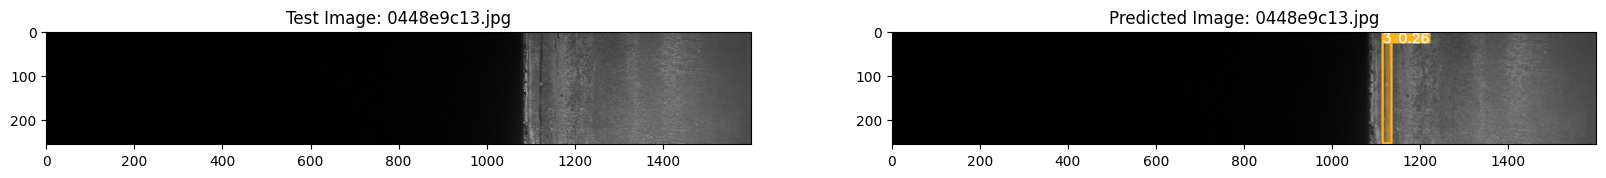

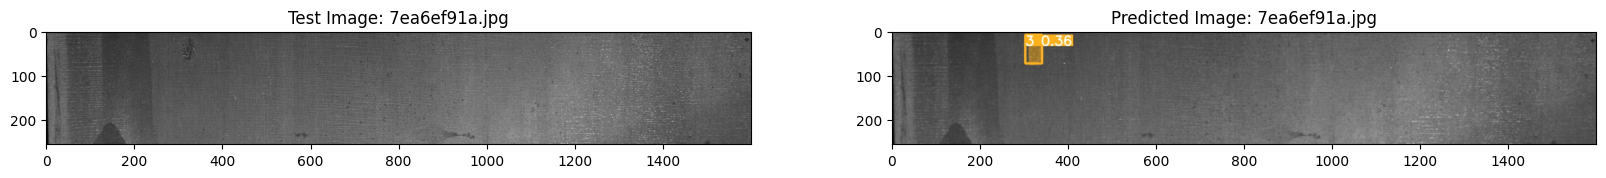

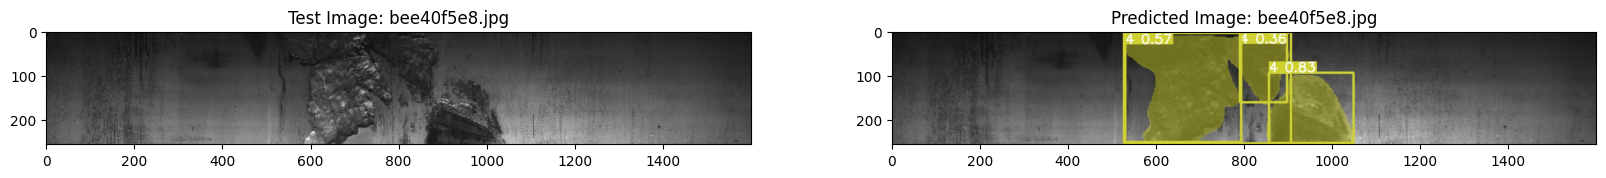

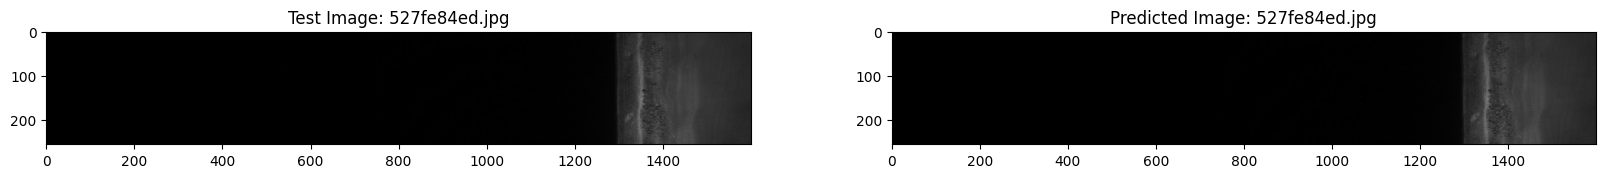

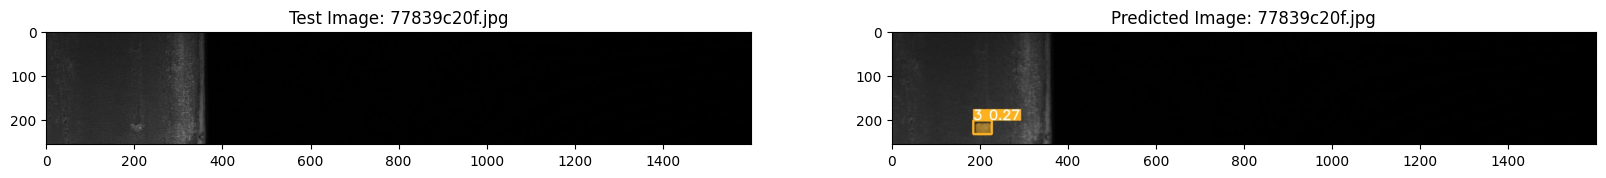

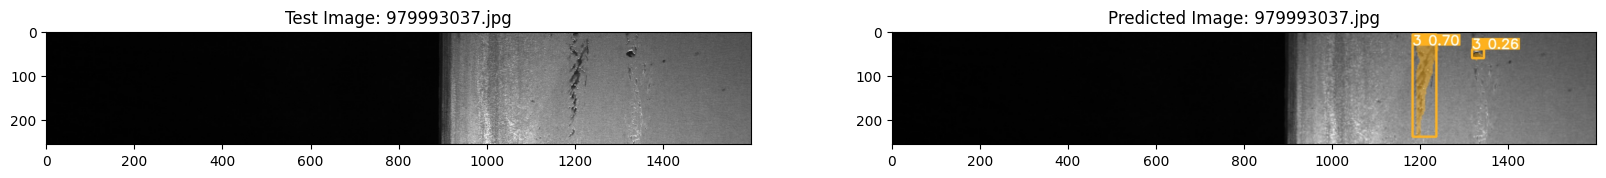

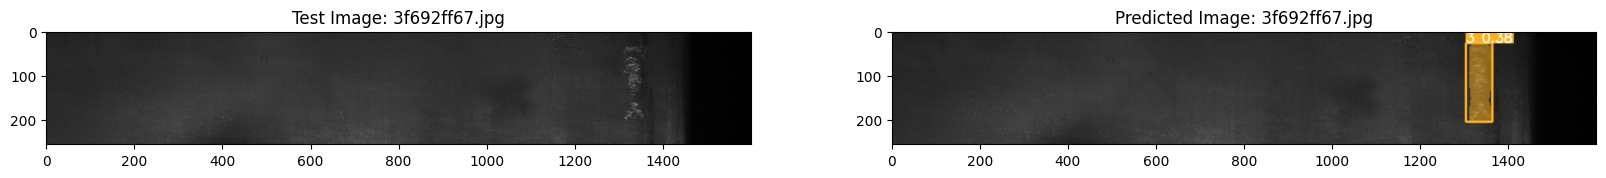

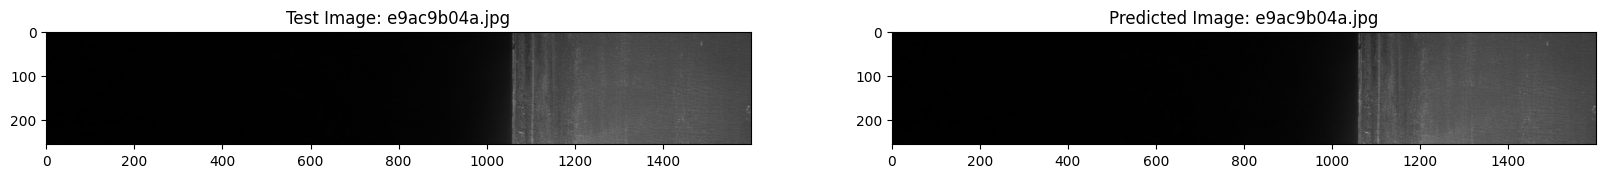

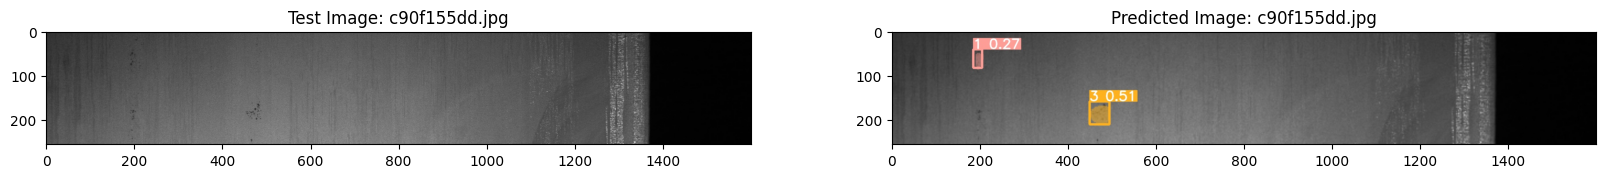

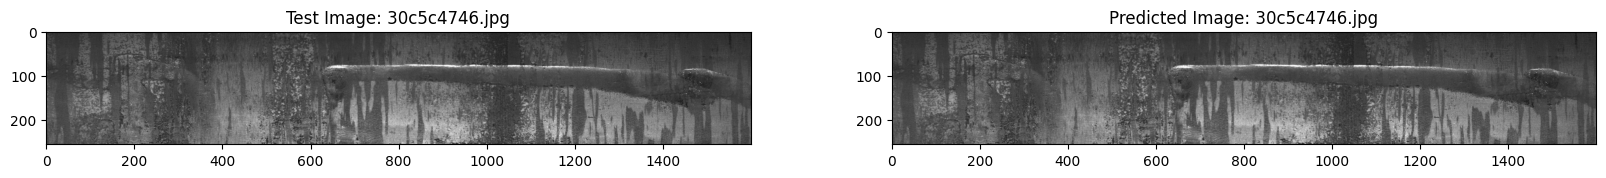

In [28]:
# выводим тестовое изображение и результат предсказания
for test_file in random_files:
    test_image_path = os.path.join(r'data\test_images', test_file)
    test_image = Image.open(test_image_path)

    # находим соответствующее предсказанное изображение
    predict_image_path = os.path.join(r'runs\segment\predict', test_file)
    predict_image = Image.open(predict_image_path)

    # создаем сетку 1x2 для вывода изображений попарно
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # выводим тестовое изображение
    axes[0].imshow(test_image)
    axes[0].set_title(f'Test Image: {test_file}')

    # выводим предсказанное изображение
    axes[1].imshow(predict_image)
    axes[1].set_title(f'Predicted Image: {test_file}')

    # отображаем изображения
    plt.show()

## Заключение

Несмотря на невысокие метрики качества обучения, предсказание имеют достаточно высокую точность. Более глубокое обучение вполне способно обеспечить высокое качество детекции дефектов